# Alzheimer prediction based on numerical data 

## Summary

In this Notebook the numerical data which is provided by the OASIS-1 dataset (https://www.oasis-brains.org) will be used as input for different classifiers with the aim to predict Alzheimer's disease. Further, the dataset for ADNI-1 will be used in the second part for the same classifier and the performance compared to the OASIS-1 dataset. In the last section, both datasets will be combined and used to predict Alzheimers. 

**NOTE**: In this notebook we will only predict healthy (= 0) and AD (=1), so it is a binary classification problem. 

### The datasets 

The OASIS-1 dataset consists of 416 subjects, of which 316 were diagnosed as being non-demented (CDR = 0, control group) and 100 with being demented ranging from very mild dementia (0.5), mild dementia (1) to moderate dementia (2). The ADNI-1 dataset contains 831 subjects. 



In [11]:
# Import all the required packages 

# Import all the required packages for data analysis and the EDA

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import os
import matplotlib.patches as mpatches
from numpy import isnan
import sys
sys.path.append('../')

#Import packages for machine learning 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

np.random.seed(42)

# Load functions to get the dataset and process it 
from preprocessing.getdata import *

In [12]:
# Import packages to see models in MLFlow 
import logging
import parsenvy

from logging import getLogger
import mlflow
from config_num import TRACKING_URI, EXPERIMENT_NAME
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='s3://neuefische-mlflow/mlflow-artifacts/56', experiment_id='56', lifecycle_stage='active', name='alzbusters_numeric_models', tags={}>

### Part 1 - The OASIS dataset 

For extended EDA of this dataset have a look into the OASIS_1_EDA_numeric.

In [13]:
#Import the dataset

df_oasis=get_csvdata_OASIS(drop_young=False, drop_contradictions=False, multiclass=False)
df_oasis.head(10)

,ID,Sex,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,label,AD,CN,MCI,Group,dataset
0,OAS1_0001_MR1,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,0,0,1,0,CN,OASIS
1,OAS1_0002_MR1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,0,0,1,0,CN,OASIS
2,OAS1_0003_MR1,F,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,1,0,0,1,MCI,OASIS
3,OAS1_0004_MR1,M,28,NaN,NaN,NaN,0.0,1588,0.803,1.105,0,0,1,0,CN,OASIS
4,OAS1_0005_MR1,M,18,NaN,NaN,NaN,0.0,1737,0.848,1.010,0,0,1,0,CN,OASIS
5,OAS1_0006_MR1,F,24,NaN,NaN,NaN,0.0,1131,0.862,1.551,0,0,1,0,CN,OASIS
6,OAS1_0007_MR1,M,21,NaN,NaN,NaN,0.0,1516,0.830,1.157,0,0,1,0,CN,OASIS
7,OAS1_0009_MR1,F,20,NaN,NaN,NaN,0.0,1505,0.843,1.166,0,0,1,0,CN,OASIS
8,OAS1_0010_MR1,M,74,5.0,2.0,30.0,0.0,1636,0.689,1.073,0,0,1,0,CN,OASIS
9,OAS1_0011_MR1,F,52,3.0,2.0,30.0,0.0,1321,0.827,1.329,0,0,1,0,CN,OASIS


In [14]:
df_oasis.drop(columns=['dataset', 'label', "Group", "AD", "CN", "MCI", "AD"], inplace=True, axis=1)

In [15]:
df_oasis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   Sex     436 non-null    object 
 2   Age     436 non-null    int64  
 3   Educ    235 non-null    float64
 4   SES     216 non-null    float64
 5   MMSE    235 non-null    float64
 6   CDR     436 non-null    float64
 7   eTIV    436 non-null    int64  
 8   nWBV    436 non-null    float64
 9   ASF     436 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 34.2+ KB


In [16]:
#For the modeling, we do not need the ID column since it does not hold any information for the prediction 
df_oasis.drop(columns=['ID'], inplace=True, axis=1)

#Create dummies for the gender column 
df_oasis=pd.get_dummies(df_oasis, columns=['Sex'], drop_first=False)

In [17]:
# Let us check how many missing values we have 
df_oasis.isnull().sum()

Age        0
Educ     201
SES      220
MMSE     201
CDR        0
eTIV       0
nWBV       0
ASF        0
Sex_F      0
Sex_M      0
dtype: int64

In [18]:
#Perform train-test split 
X= df_oasis.drop('CDR', axis=1)
y=df_oasis['CDR']
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42, stratify=y)

In [19]:
#There are only missing values in the Education, Socioeconomic and MMSE column 
#We will use the KNN nearest neighbor imputer to predict those values and fill the empty columns 


#define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit on the dataset
imputer.fit(X_train)

# transform X_train und X_test
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [20]:
#As a last step we need to scale our data 
#Use Standard Scaler for the numeric data 
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

#### 1.1 SVM

In [ ]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='1_oasis_trans_scaled_SVM')
run = mlflow.active_run()

In [ ]:
# Define hyperparameter grid for SVM
param_grid = [{'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 
               'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'auto', 'scale'],
               'C': [0.01, 0.1, 1, 10, 100],
               'degree': [2, 3, 4]
              }]

gs = GridSearchCV(SVC(), param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)

gs.fit(X_train_scaled, y_train)

# Print best parameters 
print('Best Parameters:', gs.best_params_)

# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled);

In [ ]:
# Check out the metrics
acc_train = accuracy_score(y_train, best_model.predict(X_train_scaled))
acc_test = accuracy_score(y_test, y_pred_tuned)
print(f'The accuracy on the training set is {acc_train}')
print(f'The accuracy on the test dataset is {acc_test}')

In [ ]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred_tuned.round())
cmd = ConfusionMatrixDisplay(mat, display_labels=['Healthy','AD'])
cmd.plot();

In [ ]:
#Print out the classification report 
print(classification_report(y_test, y_pred_tuned))

In [ ]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

#### 1.2 ExtraTreeClassifier 

In [ ]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='2_oasis_trans_scaled_Xtree')
run = mlflow.active_run()

In [ ]:
#We analyze the performance of the ExtraTreeClassifier using GridSearch 

param_grid = {'n_estimators': range(50,126,25),
                'criterion': ['gini', 'mse', 'mae'],
                'max_depth': [2, 8, 20, 32, 50],
                'min_samples_split': [2, 4, 6, 20, 30, 60],
                'min_samples_leaf': [1,2]
}

gs = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='f1')

gs.fit(X_train_scaled, y_train)
gs.best_params_

In [ ]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

In [ ]:
# Check out the metrics
acc_train = accuracy_score(y_train, best_model.predict(X_train_scaled))
acc_test = accuracy_score(y_test, y_pred_tuned)
print(f'The accuracy on the training set is {acc_train}')
print(f'The accuracy on the test dataset is {acc_test}')

In [ ]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred_tuned.round())
cmd = ConfusionMatrixDisplay(mat, display_labels=['Healthy','AD'])
cmd.plot();

In [ ]:
#Print out the classification report 
print(classification_report(y_test, y_pred_tuned))

In [ ]:
# Computing the importance of each feature
feature_importance = best_model.feature_importances_

# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        best_model.estimators_],
                                        axis = 0)
                        

#Plotting a Bar Graph to compare the models
plt.bar(X.columns, feature_importance_normalized)
plt.xlabel('Features')
plt.ylabel('Normalized feature importance')
plt.title('Comparison of feature importance for the OASIS dataset')
plt.show()                      

In [ ]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

### Part 2 - The ADNI dataset 

In [ ]:
#Import the dataset
df_adni=get_tadpole()
df_adni.head(10)

In [ ]:
# Let us check how many different IDs we have to make sure that we do not have the same person in test and train 
df_adni.nunique()

In [ ]:
# As the next step we remove all the columns that we do not need for our modeling 
df_adni=drop_tadpole(df_adni)
df_adni.head(2)

In [ ]:
df_adni.info()

In [ ]:
df_adni.isnull().sum()

In [ ]:
#For the modeling, we do not need the ID column since it does not hold any information for the prediction 
df_adni.drop(columns=['ID'], inplace=True, axis=1)

#Create dummies for the gender column 

df_adni=pd.get_dummies(df_adni, columns=['PTGENDER'], drop_first=False)

In [ ]:
df_adni=col_tadpole(df_adni)
df_adni

In [ ]:
df_adni.info()

In [ ]:
#Perform train-test split 
X= df_adni.drop('label', axis=1)
y=df_adni['label']
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42, stratify=y)

In [ ]:
#We will use the KNN nearest neighbor imputer to predict those values and fill the empty columns 


#define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit on the dataset
imputer.fit(X_train)

# transform X_train und X_test
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [ ]:
#As a last step we need to scale our data 
#Use Standard Scaler for the numeric data 
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

#### 2.1 SVM with Adni dataset 

In [ ]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='3_adni_trans_scaled_SVM')
run = mlflow.active_run()

In [ ]:
# Define hyperparameter grid for SVM
param_grid = [{'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 
               'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'auto', 'scale'],
               'C': [0.01, 0.1, 1, 10, 100],
               'degree': [2, 3, 4]
              }]

gs = GridSearchCV(SVC(), param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)

gs.fit(X_train_scaled, y_train)

In [ ]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

In [ ]:
# Check out the metrics
acc_train = accuracy_score(y_train, best_model.predict(X_train_scaled))
acc_test = accuracy_score(y_test, y_pred_tuned)
print(f'The accuracy of the adni on the training set is {acc_train}')
print(f'The accuracy of the adni on the test dataset is {acc_test}')

In [ ]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred_tuned.round())
cmd = ConfusionMatrixDisplay(mat, display_labels=['Healthy','AD'])
cmd.plot();

In [ ]:
#Print out the classification report 
print(classification_report(y_test, y_pred_tuned))

In [ ]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

#### 2.2 ExtraTreeClassifier on the Adni dataset 

In [ ]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='4_adni_trans_scaled_Xtree')
run = mlflow.active_run()

In [ ]:
#We analyze the performance of the ExtraTreeClassifier using GridSearch 

param_grid = {'n_estimators': range(50,126,25),
                'criterion': ['gini', 'mse', 'mae'],
                'max_depth': [2, 8, 20, 32, 50],
                'min_samples_split': [2, 4, 6, 20, 30, 60],
                'min_samples_leaf': [1,2]
}

gs = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='f1')

gs.fit(X_train_scaled, y_train)
gs.best_params_

In [ ]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

In [ ]:
# Check out the metrics
acc_train = accuracy_score(y_train, best_model.predict(X_train_scaled))
acc_test = accuracy_score(y_test, y_pred_tuned)
print(f'The accuracy on the training set is {acc_train}')
print(f'The accuracy on the test dataset is {acc_test}')

In [ ]:
probabilites = best_model.predict_proba(X_test_scaled)


In [ ]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred_tuned.round())
cmd = ConfusionMatrixDisplay(mat, display_labels=['Healthy','AD'])
cmd.plot();

In [ ]:
#Print out the classification report 
print(classification_report(y_test, y_pred_tuned))

In [ ]:
# Computing the importance of each feature
feature_importance = best_model.feature_importances_

# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        best_model.estimators_],
                                        axis = 0)
                        

#Plotting a Bar Graph to compare the models
plt.bar(X.columns, feature_importance_normalized, edgecolor=".2")
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.ylabel('Normalized feature importance')
plt.title('Comparison of feature importance for the ADNI dataset')
plt.show()  

In [ ]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

#### 3. Modeling of the brain measurements only - binary prediction 

We can see in our plot above that especially for the ADNI dataset, there is a huge influence of the cognitive tests on the prediction of Alzheimer's disease. For the next section, we will remove this from the Adni dataset and try the ExtraTree Classifier.

In [21]:
# Load the preprocessed Adni dataset (from preprocessing/ADNI_numerical_processing)
df = pd.read_csv('../data/df_ADNI_modelling.csv')

In [22]:
dftrain = df[df["Train"] == True]
dftest = df[df["Train"] == False]
df.head(2)

,Age,Ventricles,Hippocampus,WholeBrain,Entorhinal,MMSE,Imputed,ID,Sex,label,Train
0,64.0,12361.0,8333.6,1087730.0,4080.4,23.0,1.0,130_S_0956,F,1,True
1,76.0,33775.0,7590.0,1069420.0,4381.0,29.0,0.0,018_S_0043,M,0,True


In [23]:
#Drop the columns with the imputeted and train labels 
df.drop(columns=['Imputed', 'ID', "MMSE"], inplace=True, axis=1)

In [24]:
#Create a dummy column for the sex 
df = pd.get_dummies(df)

In [25]:
df.head(2)

,Age,Ventricles,Hippocampus,WholeBrain,Entorhinal,label,Train,Sex_F,Sex_M
0,64.0,12361.0,8333.6,1087730.0,4080.4,1,True,1,0
1,76.0,33775.0,7590.0,1069420.0,4381.0,0,True,0,1


In [26]:
#Perform train test split 
X=df.drop('label', axis=1)
y_train=dftrain['label']
y_test=dftest['label']

X_train = X[X["Train"] == True]
X_test = X[X["Train"] == False]

In [27]:
#As a last step we need to scale our data 
#Use Standard Scaler for the numeric data 

scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [28]:
X_train_scaled.shape

(596, 8)

In [29]:
X_train

,Age,Ventricles,Hippocampus,WholeBrain,Entorhinal,Train,Sex_F,Sex_M
0,64.0,12361.0,8333.6,1087730.0,4080.4,True,1,0
1,76.0,33775.0,7590.0,1069420.0,4381.0,True,0,1
2,76.0,30916.0,6140.0,870528.0,3671.0,True,1,0
3,78.0,39896.0,7498.0,1181030.0,3979.0,True,0,1
4,72.0,100947.0,6354.0,1200500.0,2756.0,True,0,1
...,...,...,...,...,...,...,...,...
591,66.0,17187.0,6224.0,1063190.0,2623.0,True,1,0
592,64.0,79862.0,6172.2,962038.0,3153.4,True,0,1
593,75.0,38770.0,5465.0,932074.0,2933.0,True,0,1
594,76.0,91840.0,6441.0,1087580.0,3757.0,True,0,1


In [30]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=['Age', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Train', 'Sex_F', 'Sex_M'])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=['Age', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Train', 'Sex_F', 'Sex_M'])
X_test_scaled.drop("Train", inplace=True, axis=1)
X_train_scaled.drop("Train", inplace=True, axis=1)

#### 3.1 Extra Tree Classifier on the ADNI dataset without the cognitive test results 

In [31]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='6_brain_trans_scaled_Xtree')
run = mlflow.active_run()

In [32]:
#We analyze the performance of the ExtraTreeClassifier using GridSearch 

param_grid = {'n_estimators': range(100,200,25),
                'criterion': ['gini', 'mse', 'mae'],
                'max_depth': [2, 8, 20, 32, 50],
                'min_samples_split': [2, 4, 6, 20, 30, 60],
                'min_samples_leaf': [1,2]
}

gs = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='balanced_accuracy')

gs.fit(X_train_scaled, y_train)
gs.best_params_

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.500 total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.500 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=125;, score=0.500 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=125;, score=0.500 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.500 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.500 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=0.500 total time=   0.2s
[CV 5

/Users/valentin/neuefische/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
2400 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/valentin/neuefische/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/valentin/neuefische/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/Users/valentin/neuefische/ds-capstone-alzheimers-

{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 175}

In [33]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

In [34]:
y_pred_tuned.shape  

(204,)

In [35]:
# Check out the metrics
acc_train = accuracy_score(y_train, best_model.predict(X_train_scaled))
acc_test = accuracy_score(y_test, y_pred_tuned)
print(f'The accuracy on the training set is {acc_train}')
print(f'The accuracy on the test dataset is {acc_test}')

The accuracy on the training set is 0.9983221476510067
The accuracy on the test dataset is 0.6764705882352942


In [36]:
probabilites_2 = best_model.predict_proba(X_test_scaled)

In [37]:
probabilites_2.shape

(204, 2)

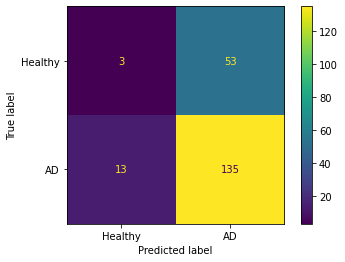

In [38]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred_tuned.round())
cmd = ConfusionMatrixDisplay(mat, display_labels=['Healthy','AD'])
cmd.plot();

In [39]:
#Print out the classification report 
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.19      0.05      0.08        56
           1       0.72      0.91      0.80       148

    accuracy                           0.68       204
   macro avg       0.45      0.48      0.44       204
weighted avg       0.57      0.68      0.61       204



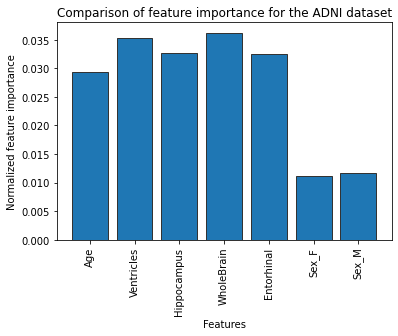

In [45]:
# Computing the importance of each feature
feature_importance = best_model.feature_importances_

# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        best_model.estimators_],
                                        axis = 0)
                        

#Plotting a Bar Graph to compare the models
plt.bar(X_test_scaled.columns, feature_importance_normalized, edgecolor=".2")
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.ylabel('Normalized feature importance')
plt.title('Comparison of feature importance for the ADNI dataset')
plt.show()  

In [46]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 0.6764705882352942, 'train-accuracy': 0.9983221476510067}, params={}, tags={'mlflow.runName': '6_brain_trans_scaled_Xtree',
 'mlflow.source.git.commit': '322c28a74247ebc6537b13bee02b71610f54107b',
 'mlflow.source.name': '/Users/valentin/neuefische/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'valentin'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/d9abd57720f641fa9df91c4f2997e7a8/artifacts', end_time=1662919521812, experiment_id='56', lifecycle_stage='active', run_id='d9abd57720f641fa9df91c4f2997e7a8', run_uuid='d9abd57720f641fa9df91c4f2997e7a8', start_time=1662919127333, status='FINISHED', user_id='valentin'>>

#### 4. Error Analysis for the ADNI dataset

For the error analysis we will add the y_pred to our X_test dataframe.  

In [47]:
#Convert X_test into a dataframe 
df_ea = pd.DataFrame(dftest)
df_ea

,Age,Ventricles,Hippocampus,WholeBrain,Entorhinal,MMSE,Imputed,ID,Sex,label,Train
596,73.0,39367.0,6146.0,850330.0,3707.0,29.0,0.0,114_S_0416,F,0,False
597,73.0,40800.0,5702.0,915118.0,3339.0,24.0,0.0,023_S_1247,F,1,False
598,88.0,79554.0,5338.0,958537.0,3317.0,24.0,0.0,128_S_1088,M,1,False
599,76.0,23794.0,6918.6,924107.0,3651.6,23.0,1.0,126_S_0784,F,1,False
600,87.0,59530.0,6326.2,945561.0,3577.4,26.0,1.0,141_S_0697,M,1,False
...,...,...,...,...,...,...,...,...,...,...,...
795,77.0,33503.0,5471.0,788112.0,3256.0,29.0,0.0,099_S_0352,F,0,False
796,79.0,29915.0,6813.0,928173.0,4048.0,30.0,0.0,027_S_0116,M,0,False
797,72.0,44550.0,5683.0,975848.0,2535.0,22.0,0.0,128_S_0740,M,0,False
798,83.0,29096.0,5946.0,959442.0,3688.0,25.0,0.0,021_S_0626,M,1,False


In [48]:
#Add the test values and the predicted values to the dataframe 
df_ea['y_test_num'] = y_test.values
df_ea['y_pred_num'] = y_pred_tuned
df_ea["probs1_num"] = probabilites_2[:,1]
df_ea

,Age,Ventricles,Hippocampus,WholeBrain,Entorhinal,MMSE,Imputed,ID,Sex,label,Train,y_test_num,y_pred_num,probs1_num
596,73.0,39367.0,6146.0,850330.0,3707.0,29.0,0.0,114_S_0416,F,0,False,0,1,0.772789
597,73.0,40800.0,5702.0,915118.0,3339.0,24.0,0.0,023_S_1247,F,1,False,1,1,0.721020
598,88.0,79554.0,5338.0,958537.0,3317.0,24.0,0.0,128_S_1088,M,1,False,1,1,0.549180
599,76.0,23794.0,6918.6,924107.0,3651.6,23.0,1.0,126_S_0784,F,1,False,1,1,0.707992
600,87.0,59530.0,6326.2,945561.0,3577.4,26.0,1.0,141_S_0697,M,1,False,1,1,0.623381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,77.0,33503.0,5471.0,788112.0,3256.0,29.0,0.0,099_S_0352,F,0,False,0,1,0.733905
796,79.0,29915.0,6813.0,928173.0,4048.0,30.0,0.0,027_S_0116,M,0,False,0,1,0.609137
797,72.0,44550.0,5683.0,975848.0,2535.0,22.0,0.0,128_S_0740,M,0,False,0,1,0.812063
798,83.0,29096.0,5946.0,959442.0,3688.0,25.0,0.0,021_S_0626,M,1,False,1,1,0.604329


In [49]:
# We write a function to add the classification (TP, TN, FP and FN) to our dataframe 
def classification(row): 
    if (row.y_test_num == 1) & (row.y_pred_num == 1): 
        return 'TP'
    if (row.y_test_num ==1 ) & (row.y_pred_num == 0): 
        return 'FN'
    if (row.y_test_num == 0) & (row.y_pred_num == 1):
        return 'FP'
    if (row.y_test_num == 0) & (row.y_pred_num == 0): 
        return 'TN'
 

df_ea['classification']=df_ea.apply(lambda row: classification (row), axis=1)

In [50]:
df_ea

,Age,Ventricles,Hippocampus,WholeBrain,Entorhinal,MMSE,Imputed,ID,Sex,label,Train,y_test_num,y_pred_num,probs1_num,classification
596,73.0,39367.0,6146.0,850330.0,3707.0,29.0,0.0,114_S_0416,F,0,False,0,1,0.772789,FP
597,73.0,40800.0,5702.0,915118.0,3339.0,24.0,0.0,023_S_1247,F,1,False,1,1,0.721020,TP
598,88.0,79554.0,5338.0,958537.0,3317.0,24.0,0.0,128_S_1088,M,1,False,1,1,0.549180,TP
599,76.0,23794.0,6918.6,924107.0,3651.6,23.0,1.0,126_S_0784,F,1,False,1,1,0.707992,TP
600,87.0,59530.0,6326.2,945561.0,3577.4,26.0,1.0,141_S_0697,M,1,False,1,1,0.623381,TP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,77.0,33503.0,5471.0,788112.0,3256.0,29.0,0.0,099_S_0352,F,0,False,0,1,0.733905,FP
796,79.0,29915.0,6813.0,928173.0,4048.0,30.0,0.0,027_S_0116,M,0,False,0,1,0.609137,FP
797,72.0,44550.0,5683.0,975848.0,2535.0,22.0,0.0,128_S_0740,M,0,False,0,1,0.812063,FP
798,83.0,29096.0,5946.0,959442.0,3688.0,25.0,0.0,021_S_0626,M,1,False,1,1,0.604329,TP


In [51]:
df_ea.to_csv("../modelling/num_predictions.csv", index=False)

In [52]:
df_ea['classification'].nunique()

4

In [53]:
# We can have a look on our Top 10 wrongly classified entries 
df_ea_fp = df_ea.query('classification == "FP"').head(10)
print(f'An example of 10 false positive (FP) entries are the following: {df_ea_fp}')

An example of 10 false positive (FP) entries are the following:       Age  Ventricles  Hippocampus  WholeBrain  Entorhinal  MMSE  Imputed  \
596  73.0     39367.0       6146.0    850330.0      3707.0  29.0      0.0   
601  76.0     29098.0       6905.0   1052840.0      4133.0  29.0      0.0   
602  76.0     96682.0       7506.0   1060960.0      4464.0  30.0      0.0   
606  78.0     20206.0       7167.0    926919.0      3307.0  30.0      0.0   
608  80.0     27138.0       5702.0   1050900.0      2423.0  28.0      0.0   
610  78.0     19606.0       7064.0   1112520.0      3516.0  28.0      0.0   
611  76.0     26012.0       7376.0    974241.0      3257.0  29.0      0.0   
615  76.0     36722.0       6865.0   1000360.0      3182.0  29.0      0.0   
618  78.0     13993.0       7686.0   1057010.0      3578.0  29.0      0.0   
624  85.0     69348.0       7176.0    999332.0      2843.0  29.0      0.0   

             ID Sex  label  Train  y_test_num  y_pred_num  probs1_num  \
596  114_S_0416

In [54]:
df_ea_fp.Age.mean()

77.6

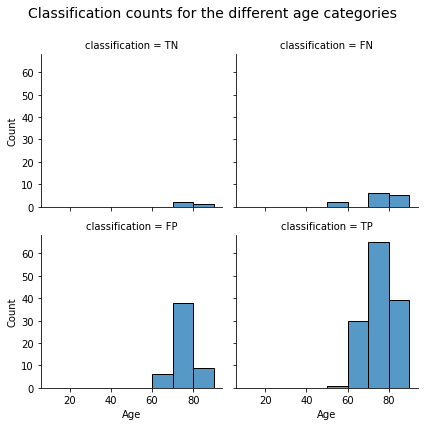

In [55]:
#Plot the classification for the Age 

plot=sns.FacetGrid(data=df_ea, col='classification', col_wrap=2, col_order=['TN', 'FN', 'FP', 'TP'])
plot.map_dataframe(sns.histplot, x='Age', binrange=(10,90), binwidth=10)
plot.fig.subplots_adjust(top=0.87)
plot.fig.suptitle('Classification counts for the different age categories', fontsize=14);

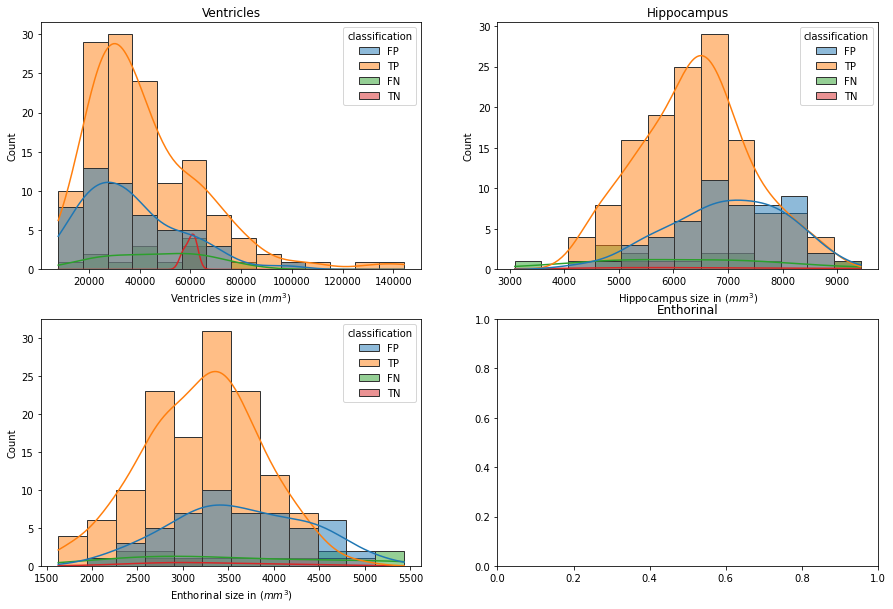

In [56]:
#Plot the classification for the Ventricles, Hippocampus,WholeBrain and	Enthorinal	 

#Create plots with all three different categories 
fig, axes = plt.subplots(2,2, figsize=(15,10))

#Ventricles
sns.histplot(ax=axes[0,0],data=df_ea, x='Ventricles', edgecolor=".2", hue='classification', kde=True).set(xlabel='Ventricles size in ($mm^3$)', ylabel='Count')
axes[0,0].set_title('Ventricles');

#Hippocampus
sns.histplot(ax=axes[0,1],data=df_ea, x='Hippocampus', edgecolor=".2", hue='classification', kde=True).set(xlabel='Hippocampus size in ($mm^3$)', ylabel='Count')
axes[0,1].set_title('Hippocampus');


#Entorhinal
sns.histplot(ax=axes[1,0],data=df_ea, x='Entorhinal', edgecolor=".2", hue='classification', kde=True).set(xlabel='Enthorinal size in ($mm^3$)', ylabel='Count')
axes[1,1].set_title('Enthorinal');

#### 5. Modeling of the brain measurements only - multiclass prediction 

In [ ]:
#Load the ADNI dataset with multiple classes 
df_mc=pd.read_csv('../modelling/df_ADNI_multiclass_modelling.csv')

In [ ]:
df_mc.head(2)

In [ ]:
#Drop the columns with the imputeted and train labels 
df_mc.drop(columns=['Imputed', 'ID', 'Unnamed: 0'], inplace=True, axis=1)

In [ ]:
#Create a dummy column for the sex 
df_mc = pd.get_dummies(df_mc, columns=['Sex'])

In [ ]:
df_mc.head(2)

In [ ]:
df_mc.isnull().sum()

In [ ]:
#Perform train test split 
X=df_mc.drop('DX', axis=1)
y=df_mc['DX']

X_train,X_test, y_train, y_test=train_test_split(X,y, random_state=42, stratify=y)

In [ ]:
#We will use the KNN nearest neighbor imputer to predict those values and fill the empty columns 


#define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit on the dataset
imputer.fit(X_train)

# transform X_train und X_test
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [ ]:
#As a last step we need to scale our data 
#Use Standard Scaler for the numeric data 
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [ ]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='7_brain_trans_scaled_multiclass_Xtree')
run = mlflow.active_run()

In [ ]:
#We analyze the performance of the ExtraTreeClassifier using GridSearch 

param_grid = {'n_estimators': range(50,126,25),
                'criterion': ['gini', 'mse', 'mae'],
                'max_depth': [2, 8, 20, 32, 50],
                'min_samples_split': [2, 4, 6, 20, 30, 60],
                'min_samples_leaf': [1,2]
}

gs = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='accuracy')

gs.fit(X_train_scaled, y_train)
gs.best_params_

In [ ]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

In [ ]:
# Check out the metrics
acc_train = accuracy_score(y_train, best_model.predict(X_train_scaled))
acc_test = accuracy_score(y_test, y_pred_tuned)
print(f'The accuracy on the training set is {acc_train}')
print(f'The accuracy on the test dataset is {acc_test}')

In [ ]:
probabilites_3 = best_model.predict_proba(X_test_scaled)

In [ ]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred_tuned)
cmd = ConfusionMatrixDisplay(mat, display_labels=['Healthy', 'MCI', 'AD'])
cmd.plot();

In [ ]:
#Print out the classification report 
print(classification_report(y_test, y_pred_tuned))

In [ ]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

#### 6. Modeling with brain data and RAVLT_immediate cognitive test 

In [ ]:
df_adni.head(2)

In [ ]:
col = ['PTEDUCAT', 'ABETA', 'TAU', 'PTAU', 'ADAS11', 'ADAS13', 'MMSE']
df_adni.drop(columns=col, inplace=True, axis=1)

In [ ]:
df_adni.isnull().sum()

In [ ]:
#Perform train test split 
X=df_adni.drop('label', axis=1)
y=df_adni['label']

X_train,X_test, y_train, y_test=train_test_split(X,y, random_state=42, stratify=y)

In [ ]:
#We will use the KNN nearest neighbor imputer to predict those values and fill the empty columns 


#define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit on the dataset
imputer.fit(X_train)

# transform X_train und X_test
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [ ]:
#As a last step we need to scale our data 
#Use Standard Scaler for the numeric data 
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [ ]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='8_brain_RAVLT_trans_scaled_Xtree')
run = mlflow.active_run()

In [ ]:
#We analyze the performance of the ExtraTreeClassifier using GridSearch 

param_grid = {'n_estimators': range(50,126,25),
                'criterion': ['gini', 'mse', 'mae'],
                'max_depth': [2, 8, 20, 32, 50],
                'min_samples_split': [2, 4, 6, 20, 30, 60],
                'min_samples_leaf': [1,2]
}

gs = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='accuracy')

gs.fit(X_train_scaled, y_train)
gs.best_params_

In [ ]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

In [ ]:
probabilites_4 = best_model.predict_proba(X_test_scaled)

In [ ]:
# Check out the metrics
acc_train = accuracy_score(y_train, best_model.predict(X_train_scaled))
acc_test = accuracy_score(y_test, y_pred_tuned)
print(f'The accuracy on the training set is {acc_train}')
print(f'The accuracy on the test dataset is {acc_test}')

In [ ]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred_tuned.round())
cmd = ConfusionMatrixDisplay(mat, display_labels=['Healthy','AD'])
cmd.plot();

In [ ]:
#Print out the classification report 
print(classification_report(y_test, y_pred_tuned))

In [ ]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)